### **Phase 1: Preliminary Analysis**

#### ***Step 1: Descriptive Statistics with Standardized Mean Differences (SMDs)***

Descriptive Statistics with Standardized Mean Differences (SMDs):
                       Variable Control_Mean Control_SD Treated_Mean  \
0                           age        74.49      55.68        77.48   
1                   sepsis_icd9         0.06       0.24         0.22   
2   White blood cell count_mean        11.50       7.84        12.21   
3              Temperature_mean        36.88       0.51        36.83   
4        Oxygen saturation_mean        96.80       2.09        96.43   
5               Creatinine_mean         1.24       1.31         1.33   
6         Respiratory rate_mean        18.58       3.45        19.48   
7       admission_type_ELECTIVE         0.18          -         0.11   
8      admission_type_EMERGENCY         0.79          -         0.88   
9         admission_type_URGENT         0.03          -         0.01   
10           first_careunit_CCU         0.16          -         0.09   
11          first_careunit_CSRU         0.20          -         0.22  

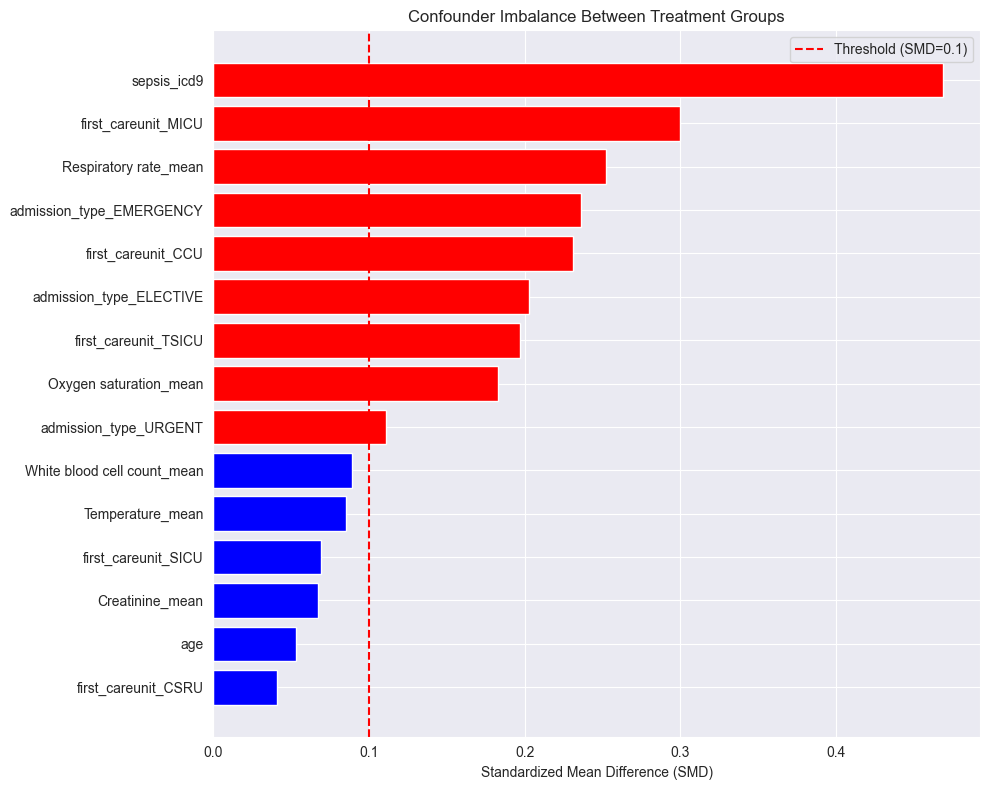


Number of imbalanced confounders (SMD > 0.1): 9
Imbalanced confounders: sepsis_icd9, Oxygen saturation_mean, Respiratory rate_mean, admission_type_ELECTIVE, admission_type_EMERGENCY, admission_type_URGENT, first_careunit_CCU, first_careunit_MICU, first_careunit_TSICU


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Load the time-to-event dataset
data = pd.read_csv("C:/MIMIC-Extract/data/antibiotics_time_to_event_cleaned.csv")

# Function to calculate standardized mean difference (SMD)
def calculate_smd(data, var, treatment_var='has_antibiotic'):
    """
    Calculate standardized mean difference for a variable between treatment groups
    """
    treated = data[data[treatment_var] == 1][var]
    control = data[data[treatment_var] == 0][var]
    
    # For continuous variables
    if data[var].dtype in [np.float64, np.int64]:
        mean_diff = treated.mean() - control.mean()
        pooled_std = np.sqrt((treated.var() + control.var()) / 2)
        if pooled_std == 0:  # Avoid division by zero
            return 0
        return abs(mean_diff / pooled_std)
    # For categorical variables 
    else:
        # Convert to dummy variables if not already binary
        if data[var].nunique() > 2:
            dummies = pd.get_dummies(data[var], prefix=var, drop_first=False)
            return {f"{var}_{col.split('_')[-1]}": calculate_smd(
                pd.concat([data[[treatment_var]], dummies], axis=1), 
                col, treatment_var) 
                for col in dummies.columns}
        # For binary variables
        else:
            p_treated = treated.mean()
            p_control = control.mean()
            return abs(p_treated - p_control) / np.sqrt((p_treated * (1 - p_treated) + p_control * (1 - p_control)) / 2)

# List of confounders
confounders = [
    'age', 'sepsis_icd9', 'White blood cell count_mean',
    'Temperature_mean', 'Oxygen saturation_mean', 'Creatinine_mean',
    'Respiratory rate_mean', 'admission_type', 'first_careunit'
]

# Calculate summary statistics and SMDs
summary_stats = pd.DataFrame(columns=['Variable', 'Control_Mean', 'Control_SD', 
                                      'Treated_Mean', 'Treated_SD', 'SMD', 'Imbalanced'])

for var in confounders:
    # Get treated and control data
    treated_data = data[data['has_antibiotic'] == 1][var]
    control_data = data[data['has_antibiotic'] == 0][var]
    
    # Calculate SMD
    if data[var].dtype in [np.float64, np.int64]:
        # Continuous variable
        treated_mean = treated_data.mean()
        treated_sd = treated_data.std()
        control_mean = control_data.mean()
        control_sd = control_data.std()
        smd = calculate_smd(data, var)
        
        # Add to summary table
        summary_stats = pd.concat([summary_stats, pd.DataFrame({
            'Variable': [var],
            'Control_Mean': [f"{control_mean:.2f}"],
            'Control_SD': [f"{control_sd:.2f}"],
            'Treated_Mean': [f"{treated_mean:.2f}"],
            'Treated_SD': [f"{treated_sd:.2f}"],
            'SMD': [f"{smd:.3f}"],
            'Imbalanced': [smd > 0.1],
        })], ignore_index=True)
    else:
        # Categorical variable - calculate proportions for each category
        control_proportions = control_data.value_counts(normalize=True)
        treated_proportions = treated_data.value_counts(normalize=True)
        
        # Handle categorical variable SMDs which returns a dictionary
        smds = calculate_smd(data, var)
        if isinstance(smds, dict):
            for cat, smd_val in smds.items():
                category = cat.split('_')[-1]
                treated_prop = treated_proportions.get(category, 0)
                control_prop = control_proportions.get(category, 0)
                summary_stats = pd.concat([summary_stats, pd.DataFrame({
                    'Variable': [f"{var}_{category}"],
                    'Control_Mean': [f"{control_prop:.2f}"],
                    'Control_SD': ["-"],
                    'Treated_Mean': [f"{treated_prop:.2f}"],
                    'Treated_SD': ["-"],
                    'SMD': [f"{smd_val:.3f}"],
                    'Imbalanced': [smd_val > 0.1],
                })], ignore_index=True)
        else:
            # Binary variable
            treated_prop = treated_data.mean()
            control_prop = control_data.mean()
            summary_stats = pd.concat([summary_stats, pd.DataFrame({
                'Variable': [var],
                'Control_Mean': [f"{control_prop:.2f}"],
                'Control_SD': ["-"],
                'Treated_Mean': [f"{treated_prop:.2f}"],
                'Treated_SD': ["-"],
                'SMD': [f"{smds:.3f}"],
                'Imbalanced': [smds > 0.1],
            })], ignore_index=True)

# Display the summary statistics and SMDs
print("Descriptive Statistics with Standardized Mean Differences (SMDs):")
print(summary_stats)

# Create a plot of SMDs
plt.figure(figsize=(10, 8))
smd_values = summary_stats['SMD'].apply(lambda x: float(x))
imbalanced = summary_stats['Imbalanced']

# Sort by SMD value
sorted_indices = smd_values.argsort().values
sorted_vars = summary_stats['Variable'].iloc[sorted_indices].values
sorted_smds = smd_values.iloc[sorted_indices].values
sorted_imbalanced = imbalanced.iloc[sorted_indices].values

colors = ['red' if imb else 'blue' for imb in sorted_imbalanced]
plt.barh(range(len(sorted_vars)), sorted_smds, color=colors)
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (SMD=0.1)')
plt.yticks(range(len(sorted_vars)), sorted_vars)
plt.xlabel('Standardized Mean Difference (SMD)')
plt.title('Confounder Imbalance Between Treatment Groups')
plt.legend()
plt.tight_layout()
plt.show()

# Display summary of key findings
imbalanced_vars = summary_stats[summary_stats['Imbalanced'] == True]['Variable'].tolist()
print(f"\nNumber of imbalanced confounders (SMD > 0.1): {len(imbalanced_vars)}")
if imbalanced_vars:
    print(f"Imbalanced confounders: {', '.join(imbalanced_vars)}")

#### ***Step 2: Non-parametric Estimation with Kaplan-Meier (KM) and IPTW-KM Curves***

##### ***Purpose: Visualizes unadjusted (KM) and adjusted (IPTW-KM) survival differences, providing context for G-formula results and highlighting the need for confounder adjustment.***

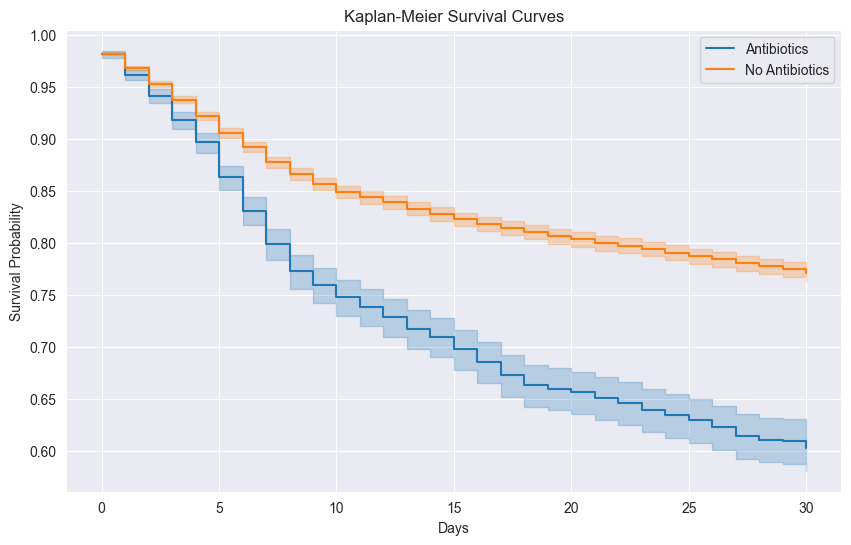

C:\Users\KhanhChang\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
C:\Users\KhanhChang\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the var

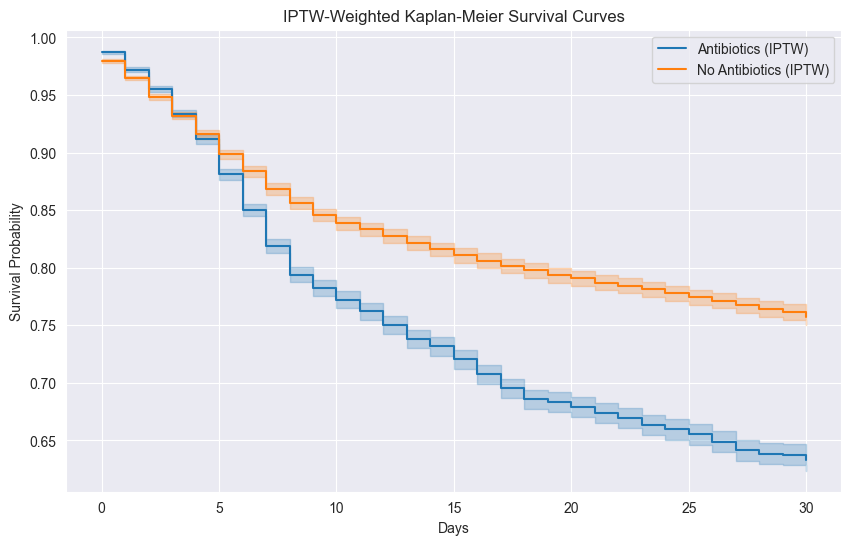

In [3]:
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# KM curves
kmf = KaplanMeierFitter()
treated = data[data["has_antibiotic"] == 1]
control = data[data["has_antibiotic"] == 0]

plt.figure(figsize=(10, 6))
kmf.fit(treated["time"], treated["status"], label="Antibiotics")
kmf.plot()
kmf.fit(control["time"], control["status"], label="No Antibiotics")
kmf.plot()
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

# IPTW-KM curves
# Prepare data
X = data[confounders].copy()
numerical_vars = [
    "age", "White blood cell count_mean", "Temperature_mean",
    "Oxygen saturation_mean", "Creatinine_mean", "Respiratory rate_mean"
]
categorical_vars = ["admission_type", "first_careunit", "sepsis_icd9"]
scaler = StandardScaler()
X[numerical_vars] = scaler.fit_transform(X[numerical_vars])
X = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
A = data["has_antibiotic"]

# Fit propensity score model
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, A)
ps_scores = ps_model.predict_proba(X)[:, 1]

# Calculate IPTW weights
weights = np.where(A == 1, 1 / ps_scores, 1 / (1 - ps_scores))
weights = np.clip(weights, 0.1, 10)  # Stabilize extreme weights

# Fit IPTW-KM
plt.figure(figsize=(10, 6))
kmf.fit(treated["time"], treated["status"], label="Antibiotics (IPTW)", weights=weights[A == 1])
kmf.plot()
kmf.fit(control["time"], control["status"], label="No Antibiotics (IPTW)", weights=weights[A == 0])
kmf.plot()
plt.title("IPTW-Weighted Kaplan-Meier Survival Curves")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

#### ***Step 3: Check Proportional Hazards Assumption***

##### ***Purpose: Validates the proportional hazards assumption for Cox models used in G-formula, ensuring model appropriateness. Violations guide reliance on AIPTW-AIPCW in Phase 3.***

Dataset shape: (33773, 16)

Value Counts for Categorical Variables:

admission_type:
admission_type
EMERGENCY    27324
ELECTIVE      5564
URGENT         885
Name: count, dtype: int64

first_careunit:
first_careunit
MICU     11993
CSRU      6830
SICU      5421
CCU       5101
TSICU     4428
Name: count, dtype: int64

sepsis_icd9:
sepsis_icd9
0    30838
1     2935
Name: count, dtype: int64

Covariate Data Types:
has_antibiotic                   int64
age                            float64
White blood cell count_mean    float64
Temperature_mean               float64
Oxygen saturation_mean         float64
Creatinine_mean                float64
Respiratory rate_mean          float64
admission_type_EMERGENCY          bool
admission_type_URGENT             bool
first_careunit_CSRU               bool
first_careunit_MICU               bool
first_careunit_SICU               bool
first_careunit_TSICU              bool
sepsis_icd9_1                     bool
dtype: object

Covariate Head:
   has_ant

<lifelines.CoxPHFitter: fitted with 33773 total observations, 29657 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 33773
number of events observed = 4116
   partial log-likelihood = -38863.55
         time fit was run = 2025-04-23 15:25:55 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
has_antibiotic               0.20      1.23      0.03            0.14            0.26                1.16                1.30
age                          0.00      1.00      0.00            0.00            0.00                1.00                1.00
White blood cell count_mean  0.01      1.01      0.00            0.01            0.01                1.01                1.01
Temperature_mean            -0.04      0.96      0.02           -0.08            0.01                0.92                1.01
Oxygen saturation_mean      -0.10      0.91      0.00           -0.10           -0.09                0.90                0.91
Creatinine_mean              0.06      1.07      0.01            0.05            0.08                1.05                1.08
Respiratory rate_mean        0.03      1.03      0.00            0.02            0.03                1.02                1.03
admission_type_EMERGENCY     0.34      1.41      0.03            0.27            0.41                1.31                1.50
admission_type_URGENT        0.16      1.18      0.08            0.01            0.31                1.01                1.36
first_careunit_CSRU         -0.30      0.74      0.03           -0.37           -0.23                0.69                0.79
first_careunit_MICU          0.10      1.10      0.03            0.05            0.15                1.05                1.16
first_careunit_SICU          0.17      1.19      0.03            0.11            0.24                1.11                1.27
first_careunit_TSICU         0.15      1.17      0.04            0.08            0.23                1.08                1.26
sepsis_icd9_1                0.55      1.74      0.03            0.49            0.62                1.63                1.86

                             cmp to      z      p  -log2(p)
covariate                                                  
has_antibiotic                 0.00   6.78 <0.005     36.24
age                            0.00   7.36 <0.005     42.30
White blood cell count_mean    0.00  16.41 <0.005    198.58
Temperature_mean               0.00  -1.61   0.11      3.20
Oxygen saturation_mean         0.00 -34.40 <0.005    859.11
Creatinine_mean                0.00   8.43 <0.005     54.72
Respiratory rate_mean          0.00   8.06 <0.005     50.17
admission_type_EMERGENCY       0.00   9.85 <0.005     73.67
admission_type_URGENT          0.00   2.13   0.03      4.92
first_careunit_CSRU            0.00  -8.69 <0.005     57.96
first_careunit_MICU            0.00   3.75 <0.005     12.45
first_careunit_SICU            0.00   5.23 <0.005     22.52
first_careunit_TSICU           0.00   4.15 <0.005     14.88
sepsis_icd9_1                  0.00  16.28 <0.005    195.66
---
Concordance = 0.72
Partial AIC = 77755.10
log-likelihood ratio test = 1722.91 on 14 df
-log2(p) of ll-ratio test = inf


Proportional Hazards Assumption Check:
Checking assumptions with covariates: ['has_antibiotic', 'age', 'White blood cell count_mean', 'Temperature_mean', 'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean', 'admission_type_EMERGENCY', 'admission_type_URGENT', 'first_careunit_CSRU', 'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU', 'sepsis_icd9_1']

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant line

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 33773 total observations, 29657 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Creatinine_mean             km             48.70 <0.005     38.29
                            rank           49.16 <0.005     38.62
Oxygen saturation_mean      km             74.57 <0.005     57.24
                            rank           82.40 <0.005     62.96
Respiratory rate_mean       km              0.13   0.72      0.47
                            rank            0.14   0.70      0.51
Temperature_mean            km              5.12   0.02      5.40
                            rank            2.49   0.11      3.12
White blood cell count_mean km              1.12   0.29      1.78
                            rank            1.15   0.28      1.82
admission_type_EMERGENCY    km              0.50   0.48      1.05
                            rank            0.38   0.54      0.90
admission_type_URGENT       km              0.46   0.50      1.01
                            rank            0.68   0.41      1.29
age                         km              6.97   0.01      6.91
                            rank            8.49 <0.005      8.13
first_careunit_CSRU         km              3.51   0.06      4.04
                            rank            3.55   0.06      4.07
first_careunit_MICU         km              8.34 <0.005      8.01
                            rank            7.27   0.01      7.16
first_careunit_SICU         km              4.30   0.04      4.72
                            rank            3.48   0.06      4.01
first_careunit_TSICU        km              3.81   0.05      4.30
                            rank            3.35   0.07      3.89
has_antibiotic              km             21.92 <0.005     18.42
                            rank           47.83 <0.005     37.64
sepsis_icd9_1               km             12.92 <0.005     11.59
                            rank           16.25 <0.005     14.14



1. Variable 'has_antibiotic' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['has_antibiotic', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'age' failed the non-proportional test: p-value is 0.0036.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess li

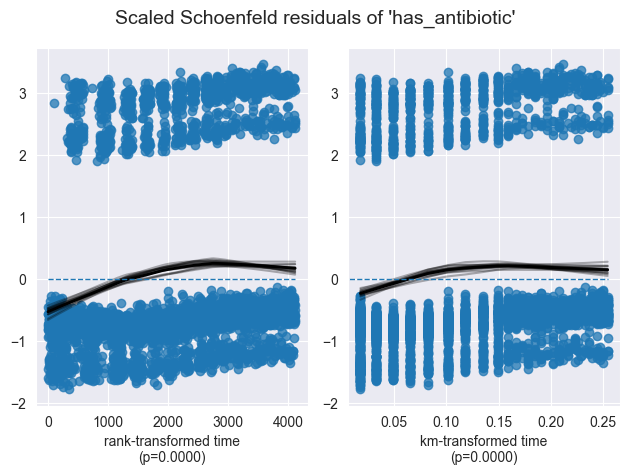

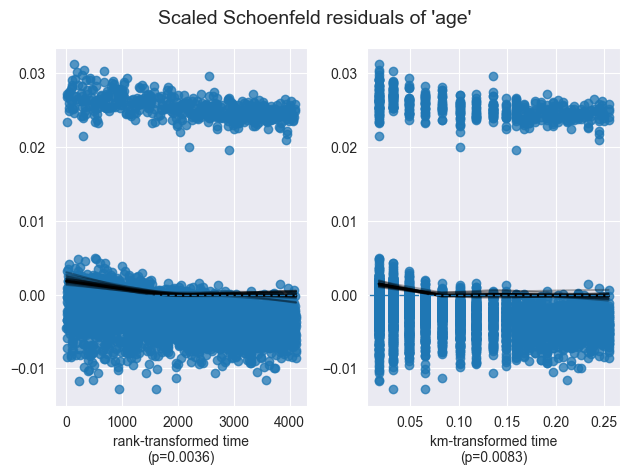

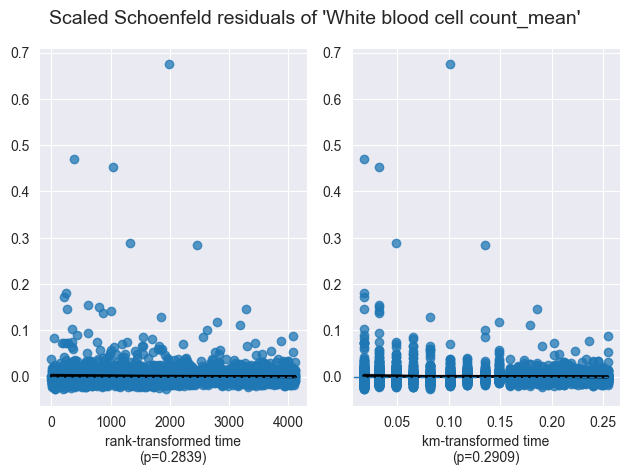

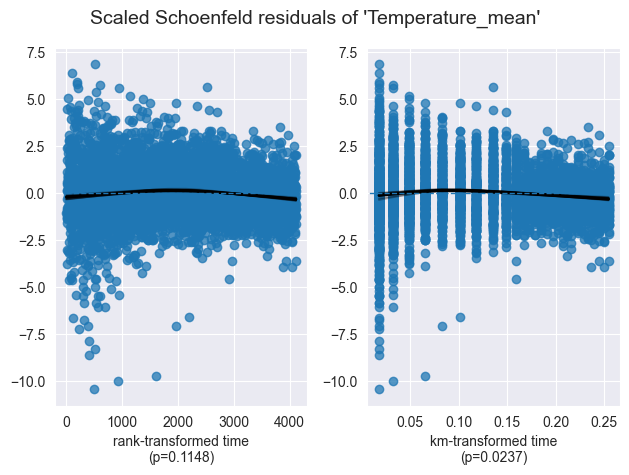

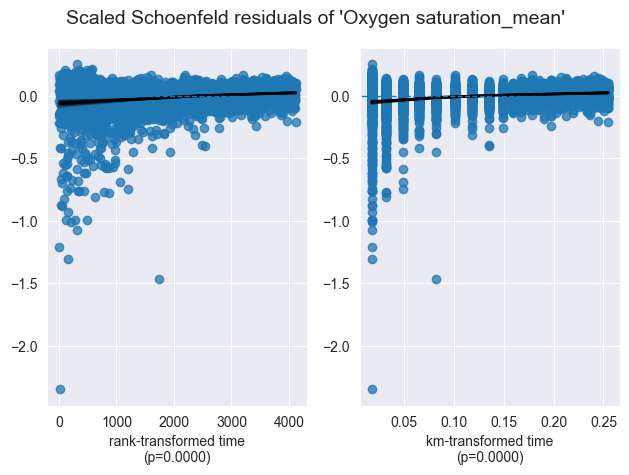

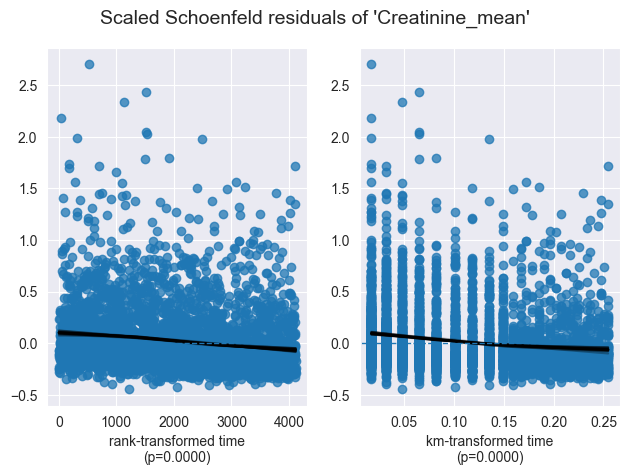

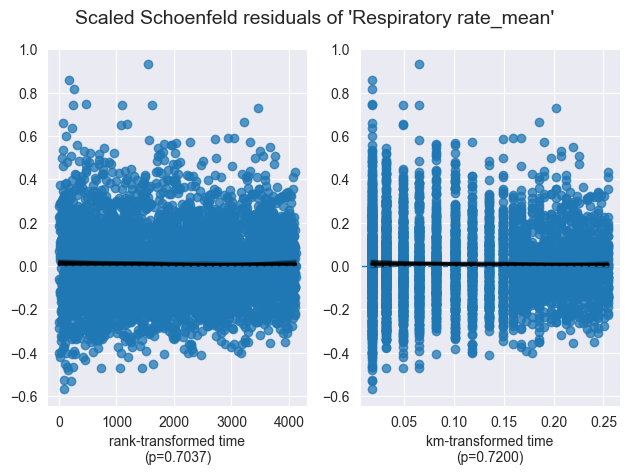

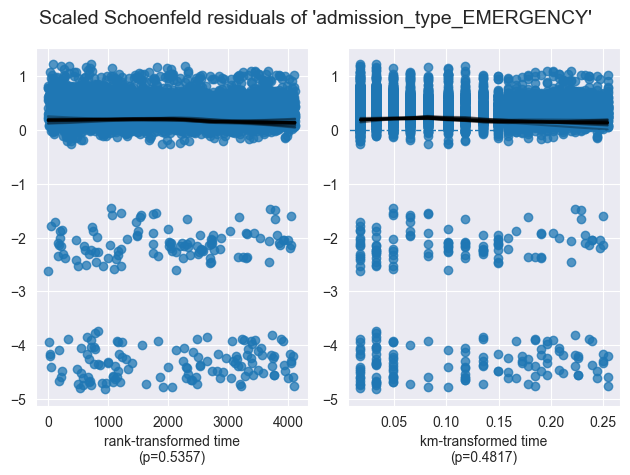

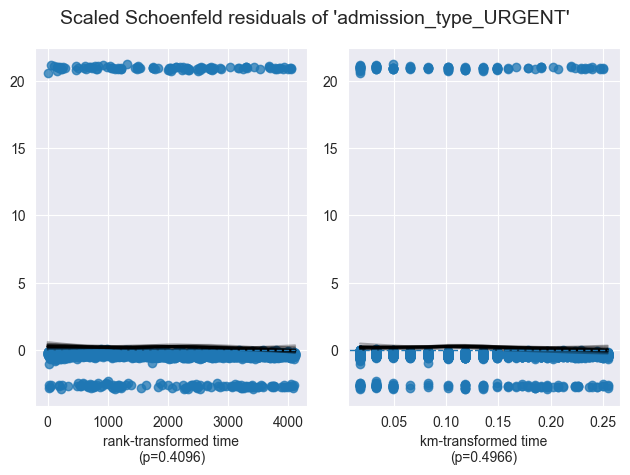

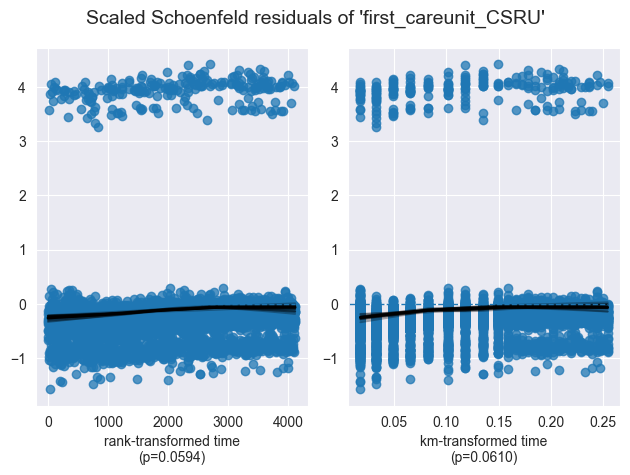

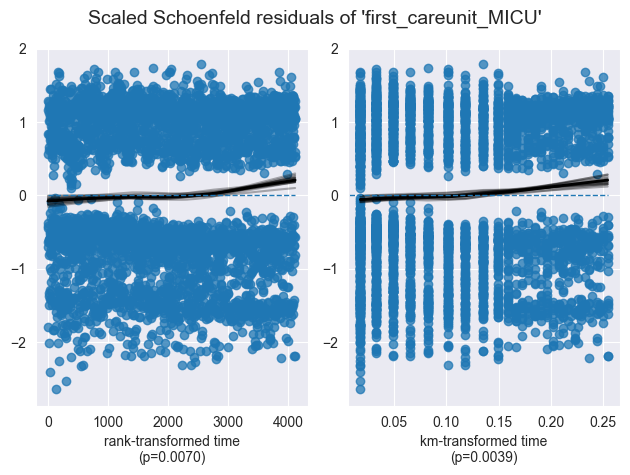

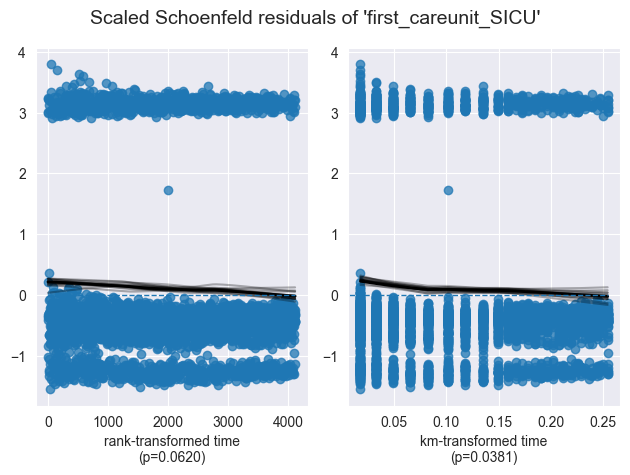

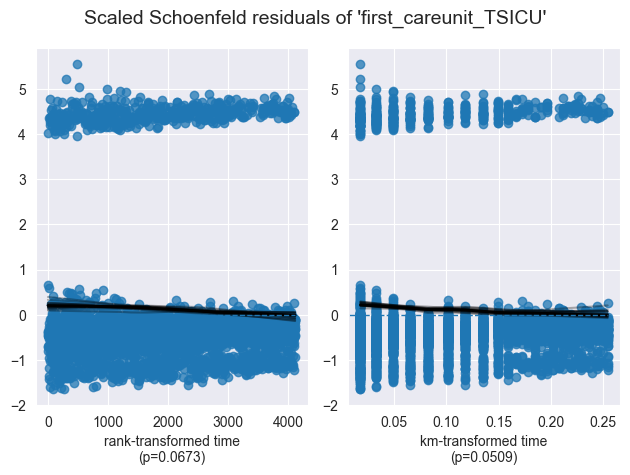

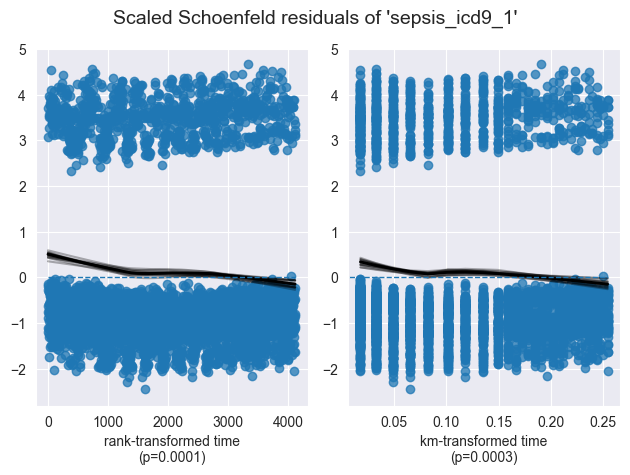

In [4]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Load cleaned dataset
data = pd.read_csv("C:/MIMIC-Extract/data/antibiotics_time_to_event_cleaned.csv")
print(f"Dataset shape: {data.shape}")

# Inspect categorical variables
print("\nValue Counts for Categorical Variables:")
for col in ["admission_type", "first_careunit", "sepsis_icd9"]:
    print(f"\n{col}:\n{data[col].value_counts(dropna=False)}")

# Ensure sepsis_icd9 is binary
data["sepsis_icd9"] = data["sepsis_icd9"].astype(int)

# Prepare data for Cox model
cox_data = data.copy()
cox_data = pd.get_dummies(cox_data, columns=["admission_type", "first_careunit", "sepsis_icd9"], drop_first=True)
covariates = ["has_antibiotic", "age", "White blood cell count_mean",
              "Temperature_mean", "Oxygen saturation_mean", "Creatinine_mean",
              "Respiratory rate_mean"] + [col for col in cox_data.columns if "admission_type_" in col or "first_careunit_" in col or "sepsis_icd9" in col]

# Check data types and head
print("\nCovariate Data Types:")
print(cox_data[covariates].dtypes)
print("\nCovariate Head:")
print(cox_data[covariates].head())

# Check correlations
continuous_vars = ["age", "White blood cell count_mean", "Temperature_mean",
                  "Oxygen saturation_mean", "Creatinine_mean", "Respiratory rate_mean"]
print("\nCorrelation Matrix for Continuous Variables:")
corr_matrix = cox_data[continuous_vars].corr()
print(corr_matrix)

# Compute VIF
X_vif = cox_data[covariates].copy()
X_vif = X_vif.astype(float)
scaler = StandardScaler()
X_vif[continuous_vars] = scaler.fit_transform(X_vif[continuous_vars])
X_vif = X_vif.fillna(0).replace([np.inf, -np.inf], 0)
if not X_vif.apply(lambda x: pd.to_numeric(x, errors="coerce").notnull().all()).all():
    print("\nWarning: Non-numeric values detected in X_vif:")
    print(X_vif.apply(lambda x: pd.to_numeric(x, errors="coerce").isnull().sum()))
else:
    print("\nAll covariates are numeric.")

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
try:
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print("\nVIF Scores:")
    print(vif_data.sort_values("VIF", ascending=False))
except Exception as e:
    print(f"\nError calculating VIF: {e}")
    print("Falling back to penalized Cox model without VIF pruning.")

# Remove high VIF covariates (VIF > 10)
if "VIF" in vif_data.columns:
    high_vif = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()
    if high_vif:
        print(f"\nRemoving high VIF covariates: {high_vif}")
        covariates = [c for c in covariates if c not in high_vif]
    else:
        print("\nNo high VIF covariates found.")
else:
    print("\nVIF calculation failed; proceeding with all covariates and penalizer.")

# Fit Cox model (Initial)
cox = CoxPHFitter(penalizer=0.1)
fit_data = cox_data[["time", "status"] + covariates]
print(f"\nShape of fit_data: {fit_data.shape}")
print(f"Expected covariates: {len(covariates)}")
try:
    cox.fit(fit_data, duration_col="time", event_col="status")
    print("\nCox Model Summary:")
    cox.print_summary()

    # Check proportional hazards
    print("\nProportional Hazards Assumption Check:")
    print(f"Checking assumptions with covariates: {covariates}")
    cox.check_assumptions(fit_data, p_value_threshold=0.05, show_plots=True)
except Exception as e:
    print(f"\nError in initial Cox model: {e}")
    print("Retrying with reduced covariates (excluding first_careunit).")
    # Fallback: Exclude first_careunit
    covariates = ["has_antibiotic", "age", "White blood cell count_mean",
                  "Temperature_mean", "Oxygen saturation_mean", "Creatinine_mean",
                  "Respiratory rate_mean"] + [col for col in cox_data.columns if "admission_type_" in col or "sepsis_icd9" in col]
    fit_data = cox_data[["time", "status"] + covariates]
    print(f"\nShape of fallback fit_data: {fit_data.shape}")
    print(f"Expected covariates: {len(covariates)}")
    cox = CoxPHFitter(penalizer=0.5)
    try:
        cox.fit(fit_data, duration_col="time", event_col="status")
        print("\nCox Model Summary (Fallback):")
        cox.print_summary()
        print("\nProportional Hazards Assumption Check (Fallback):")
        cox.check_assumptions(fit_data, p_value_threshold=0.05, show_plots=True)
    except Exception as e:
        print(f"\nFallback failed: {e}")
        print("Proceed with AIPTW-AIPCW in Phase 3 as primary method.")

# Expected Output:
# - Value counts for categorical variables
# - Covariate types and head
# - Correlation matrix
# - VIF scores
# - Cox model summary
# - Schoenfeld residuals test (p-values < 0.05 indicate violations)
# - Plots of residuals vs. time

#### ***Step 4: Propensity Score Diagnostics***

##### ***Purpose: Confirms sufficient overlap in confounder distributions (positivity assumption), ensuring G-formula’s counterfactual predictions are reliable.***



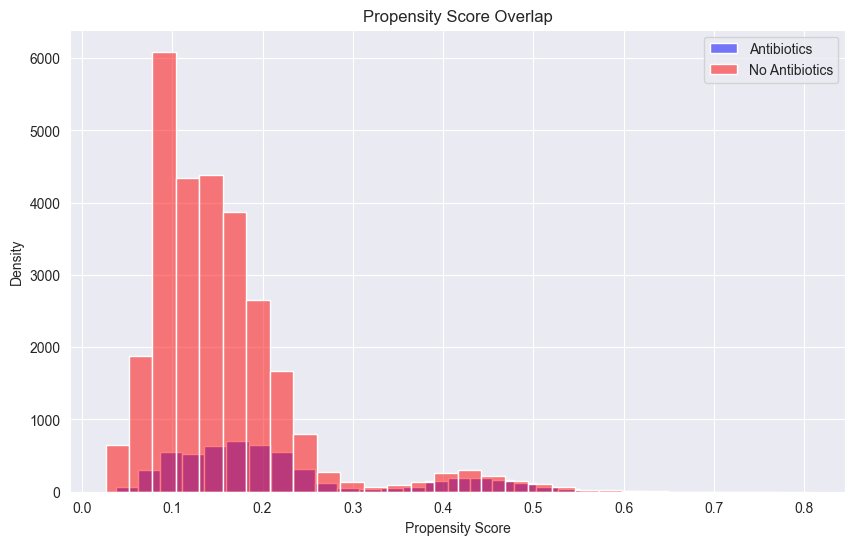


Propensity Score Range:
Antibiotics: [0.037, 0.772]
No Antibiotics: [0.026, 0.806]


In [5]:
import seaborn as sns

# Use propensity scores from Step 2
plt.figure(figsize=(10, 6))
sns.histplot(ps_scores[A == 1], label="Antibiotics", color="blue", alpha=0.5, bins=30)
sns.histplot(ps_scores[A == 0], label="No Antibiotics", color="red", alpha=0.5, bins=30)
plt.title("Propensity Score Overlap")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# Check range of propensity scores
print("\nPropensity Score Range:")
print(f"Antibiotics: [{ps_scores[A == 1].min():.3f}, {ps_scores[A == 1].max():.3f}]")
print(f"No Antibiotics: [{ps_scores[A == 0].min():.3f}, {ps_scores[A == 0].max():.3f}]")

# Expected Output:
# - Histogram showing propensity score distributions
# - Good overlap if distributions largely coincide
# - Range near [0, 1] indicates potential positivity issues

#### ***Step 5: Trim Propensity Scores to Improve Overlap***

Original dataset size: 33773
Trimmed dataset size: 33190
Patients removed: 583


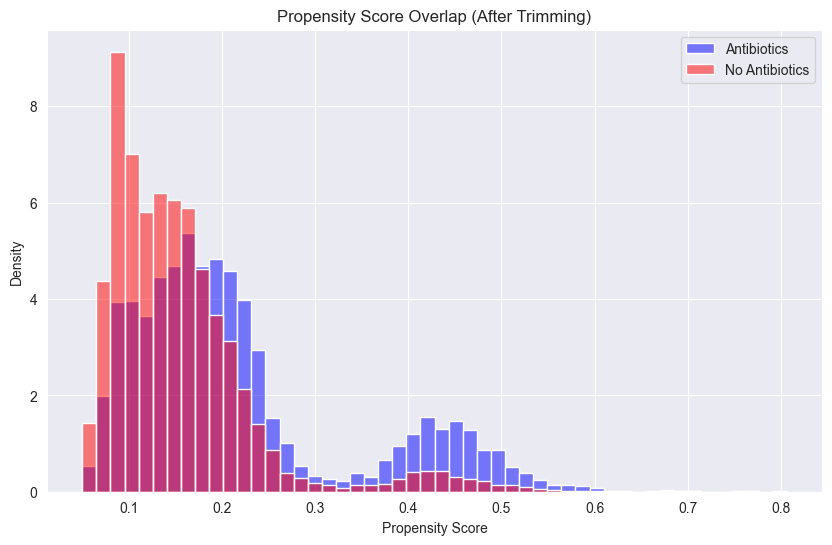

Propensity Score Range (After Trimming):
Antibiotics: [0.050, 0.772]
No Antibiotics: [0.050, 0.806]


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Compute propensity scores (if not already in `data`)
if 'prop_score' not in data.columns:
    X = pd.get_dummies(data[['age', 'White blood cell count_mean', 'Temperature_mean',
                             'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean',
                             'admission_type', 'first_careunit', 'sepsis_icd9']],
                       columns=['admission_type', 'first_careunit', 'sepsis_icd9'], drop_first=True)
    numerical_vars = ['age', 'White blood cell count_mean', 'Temperature_mean',
                     'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean']
    X[numerical_vars] = StandardScaler().fit_transform(X[numerical_vars])
    A = data['has_antibiotic']
    model_t = LogisticRegression()
    model_t.fit(X, A)
    prop_scores = model_t.predict_proba(X)[:, 1]
    data['prop_score'] = prop_scores
else:
    print("Propensity scores already in `data`.")

# Trim propensity scores (e.g., keep scores in [0.05, 0.95])
trim_lower, trim_upper = 0.05, 0.95
trim_mask = (data['prop_score'] >= trim_lower) & (data['prop_score'] <= trim_upper)
data_trimmed = data[trim_mask].copy()
print(f"Original dataset size: {len(data)}")
print(f"Trimmed dataset size: {len(data_trimmed)}")
print(f"Patients removed: {len(data) - len(data_trimmed)}")

# Replot propensity score overlap after trimming
plt.figure(figsize=(10, 6))
sns.histplot(data=data_trimmed, x='prop_score', hue='has_antibiotic', stat='density', common_norm=False,
             bins=50, alpha=0.5, palette={1: 'blue', 0: 'red'})
plt.title('Propensity Score Overlap (After Trimming)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(labels=['Antibiotics', 'No Antibiotics'])
plt.show()

# Check new ranges
print("Propensity Score Range (After Trimming):")
print(f"Antibiotics: [{data_trimmed[data_trimmed['has_antibiotic'] == 1]['prop_score'].min():.3f}, "
      f"{data_trimmed[data_trimmed['has_antibiotic'] == 1]['prop_score'].max():.3f}]")
print(f"No Antibiotics: [{data_trimmed[data_trimmed['has_antibiotic'] == 0]['prop_score'].min():.3f}, "
      f"{data_trimmed[data_trimmed['has_antibiotic'] == 0]['prop_score'].max():.3f}]")

#### ***Step 6: Apply Propensity Score Matching to Balance Confounders***

Matched dataset size: 11044

Balance Check After Matching:
SMD for age: -0.000
SMD for White blood cell count_mean: -0.018
SMD for Temperature_mean: -0.027
SMD for Oxygen saturation_mean: -0.011
SMD for Creatinine_mean: -0.012
SMD for Respiratory rate_mean: -0.034

admission_type distribution:
has_antibiotic  admission_type
0               EMERGENCY         0.889352
                ELECTIVE          0.099602
                URGENT            0.011047
1               EMERGENCY         0.885911
                ELECTIVE          0.102499
                URGENT            0.011590
Name: proportion, dtype: float64

first_careunit distribution:
has_antibiotic  first_careunit
0               MICU              0.470482
                CSRU              0.231438
                SICU              0.136183
                CCU               0.085114
                TSICU             0.076784
1               MICU              0.479174
                CSRU              0.217313
                SICU 

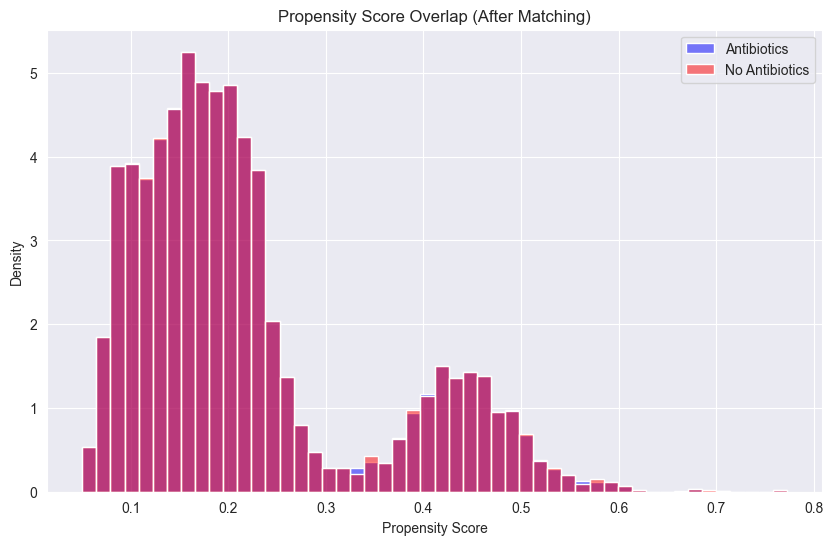

In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Ensure propensity scores are in `data_trimmed`
if 'prop_score' not in data_trimmed.columns:
    X = pd.get_dummies(data_trimmed[['age', 'White blood cell count_mean', 'Temperature_mean',
                                     'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean',
                                     'admission_type', 'first_careunit', 'sepsis_icd9']],
                       columns=['admission_type', 'first_careunit', 'sepsis_icd9'], drop_first=True)
    numerical_vars = ['age', 'White blood cell count_mean', 'Temperature_mean',
                     'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean']
    X[numerical_vars] = StandardScaler().fit_transform(X[numerical_vars])
    A = data_trimmed['has_antibiotic']
    model_t = LogisticRegression()
    model_t.fit(X, A)
    prop_scores = model_t.predict_proba(X)[:, 1]
    data_trimmed['prop_score'] = prop_scores

# Separate treated and control groups
treated = data_trimmed[data_trimmed['has_antibiotic'] == 1].copy()
control = data_trimmed[data_trimmed['has_antibiotic'] == 0].copy()

# Apply 1:1 nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(control[['prop_score']])
distances, indices = nn.kneighbors(treated[['prop_score']])

# Create matched dataset
matched_control = control.iloc[indices.flatten()].copy()
matched_control['match_id'] = treated.index
treated['match_id'] = treated.index
data_matched = pd.concat([treated, matched_control], axis=0)

# Verify balance after matching
print(f"Matched dataset size: {len(data_matched)}")
print("\nBalance Check After Matching:")
confounders = ['age', 'White blood cell count_mean', 'Temperature_mean',
               'Oxygen saturation_mean', 'Creatinine_mean', 'Respiratory rate_mean',
               'admission_type', 'first_careunit', 'sepsis_icd9']
for var in confounders:
    if var in ['admission_type', 'first_careunit', 'sepsis_icd9']:
        # For categorical variables
        print(f"\n{var} distribution:")
        print(data_matched.groupby('has_antibiotic')[var].value_counts(normalize=True))
    else:
        # For continuous variables, compute standardized mean difference (SMD)
        mean_treated = data_matched[data_matched['has_antibiotic'] == 1][var].mean()
        mean_control = data_matched[data_matched['has_antibiotic'] == 0][var].mean()
        std_treated = data_matched[data_matched['has_antibiotic'] == 1][var].std()
        std_control = data_matched[data_matched['has_antibiotic'] == 0][var].std()
        smd = (mean_treated - mean_control) / np.sqrt((std_treated**2 + std_control**2) / 2)
        print(f"SMD for {var}: {smd:.3f}")

# Replot propensity score overlap after matching
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(data=data_matched, x='prop_score', hue='has_antibiotic', stat='density', common_norm=False,
             bins=50, alpha=0.5, palette={1: 'blue', 0: 'red'})
plt.title('Propensity Score Overlap (After Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(labels=['Antibiotics', 'No Antibiotics'])
plt.show()

In [8]:
# Save the trimmed dataset and matched dataset to a CSV file
output_path1 = "D:/prethesis/data/antibiotics_time_to_event_trimmed.csv"
data_trimmed.to_csv(output_path1, index=False)
print(f"Trimmed dataset saved to: {output_path1}")

output_path2 = "D:/prethesis/data/antibiotics_time_to_event_matched.csv"
data_matched.to_csv(output_path2, index=False)
print(f"Matched dataset saved to: {output_path2}")

Trimmed dataset saved to: D:/prethesis/data/antibiotics_time_to_event_trimmed.csv
Matched dataset saved to: D:/prethesis/data/antibiotics_time_to_event_matched.csv
